In [116]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd

inds_to_data = pd.read_csv('edges.csv', header=None, names=['move', 'player', 'start', 'end', 'selected'])
players, player_indices = np.unique(inds_to_data['player'].to_numpy(), return_inverse=True)
inds_to_data['player'] = player_indices
moves = inds_to_data['move'].to_numpy()
starts = inds_to_data['start'].to_numpy()
ends = inds_to_data['end'].to_numpy()
ndots = len(np.unique(ends))

X = np.zeros((len(np.unique(moves)), len(np.unique(players)), ndots, ndots), dtype=bool)

X[moves-1, player_indices, starts-1, ends-1] = inds_to_data['selected'].to_numpy().round().astype(bool)
# X = X[:, 0:, :, :]

dots = pd.read_csv('dots.csv')
dots.set_index(['set', 'dot_id'], inplace=True)
# dots.loc[(1, 1)].tolist()
# dots
dots

x     y
set dot_id          
1   1        0  10.0
    2        5  10.0
    3       -5  10.0
    4      -10  10.0
    5       10  10.0
    6        0  20.0
    7        5  20.0
    8       -5  20.0
    9      -10  20.0
    10      10  20.0
    11       0  15.0
    12       5  15.0
    13      -5  15.0
    14     -10  15.0
    15      10  15.0
    16       0  25.0
    17       5  25.0
    18      -5  25.0
    19     -10  25.0
    20      10  25.0
2   1        0  15.0
    2        2  18.0
    3        4  21.0
    4        6  23.0
    5        8  24.5
    6       10  25.0
    7       12  24.5
    8       14  23.0
    9       16  21.0
    10      18  18.0
    11      20  15.0
    12      -2  12.0
    13      -4   9.0
    14      -6   7.0
    15      -8   5.5
    16     -10   5.0
    17     -12   5.5
    18     -14   7.0
    19     -16   9.0
    20     -18  12.0
3   1       15  20.0
    2       12  29.0
    3        5  34.0
    4       -5  34.0
    5      -12  29.0
    6      -15  20.0
    7      -12  11.0
    8       -5   6.0
    9        5   6.0
    10      12  11.0
    11       8  22.0
    12       5  26.0
    13       0  28.0
    14      -5  26.0
    15      -8  22.0
    16      -8  18.0
    17      -5  14.0
    18       0  12.0
    19       5  14.0
    20       8  18.0

# Marching Band Form Transition Visualizations

This notebook visualizes the dot assignments for marching band form transitions.

## Data Structure
- **X**: 4D array with shape `(n_moves, n_players, n_dots_from, n_dots_to)`
  - Dimension 1: **Moves** - transitions from one set to another
  - Dimension 2: **Players** - individual band members
  - Dimension 3: **From** - starting dot position (1-indexed)
  - Dimension 4: **To** - ending dot position (1-indexed)
- **dots**: DataFrame with columns `[set, dot_id, x, y]` containing coordinates in yards
- **players**: Array of player names

## Visualization Features
- Football field diagram as background
- **Light blue circles**: Starting positions (previous set)
- **Dark blue circles**: Ending positions (current set)
- **Red arrows**: Movement paths from start to end
- **Yellow labels**: Player names at ending positions
- **Dot numbers** (optional): Can be shown/hidden with `show_dot_numbers` parameter
- **Coordinate system**: Centered at (0,0) with axes labeled in yards

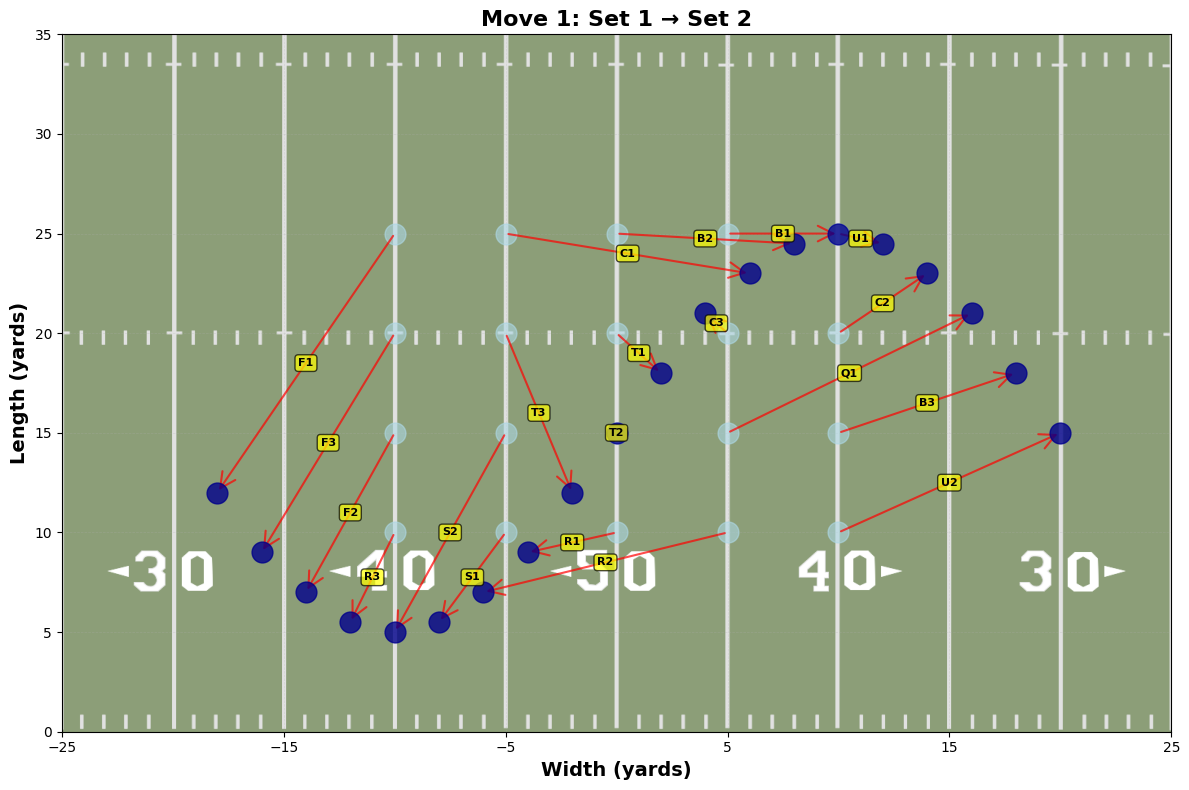

In [137]:
from PIL import Image

def visualize_move(move_idx, show_dot_numbers=True, crop=True, figsize=(12, 8)):
    """
    Visualize a single move transition on top of football field diagram.
    
    Parameters:
    - move_idx: 0-indexed move number (0 corresponds to Move 1)
    - show_dot_numbers: Whether to show dot numbers on circles
    - figsize: Figure size in inches
    """
    # Load the football field image
    if crop:
        field_width  = 35
        field_length = 50
        field_img = Image.open('football_field_diagram_subset.png')
    else:
        # Assuming standard football field: 160 feet (53.33 yards) wide x 360 feet (100 yards) long
        # We'll center at (0, 0) so range from -26.67 to 26.67 yards horizontally
        # and -60 to 60 yards vertically
        field_width = 53.33  # yards
        field_length = 100   # yards
        field_img = Image.open('football_field_diagram.png')
    ex = [-field_length/2, field_length/2, 0, field_width]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    # Display the field image
    ax.imshow(field_img, extent=ex, aspect='auto', alpha=0.7)
    
    # Get the move data for this move
    move_data = X[move_idx]  # Shape: (n_players, n_dots, n_dots)
    n_players = move_data.shape[0]
    
    # Extract from and to positions for each player
    player_transitions = []
    for player_idx in range(n_players):
        # Find the (from, to) pair where value is 1
        from_to = np.argwhere(move_data[player_idx] == 1)
        player_transitions.append((player_idx, from_to[0, 0],  from_to[0, 1]))
    
    # Plot FROM positions (light color, smaller)
    for (player_idx, from_dot, to_dot) in player_transitions:
        # Mind your 1-indexing
        from_x, from_y = dots.loc[(move_idx+1, int(from_dot+1))].tolist()
        to_x, to_y = dots.loc[(move_idx+2, int(to_dot+1))].tolist()
        ax.plot(from_x, from_y, 'o', color='lightblue', markersize=15, alpha=0.6, zorder=2)
        ax.plot(to_x, to_y, 'o', color='darkblue', markersize=15, alpha=0.8, zorder=4)
        if show_dot_numbers:
            ax.text(from_x, from_y, str(from_dot+1), ha='center', va='center', 
                    fontsize=9, color='black', weight='bold', zorder=5)
            ax.text(to_x, to_y, str(to_dot+1), ha='center', va='center', 
                    fontsize=9, color='white', weight="bold", zorder=5)
        # Draw arrow
        ax.annotate('', xy=(to_x, to_y), xytext=(from_x, from_y),
                    arrowprops=dict(arrowstyle='->', lw=1.5, mutation_scale=28, color='red', alpha=0.7),
                    zorder=3)
        
        # Add player name at ending position (offset slightly to avoid overlap)
        player_name = players[player_idx]
        ax.text((from_x+to_x)/2, (from_y+to_y)/2, player_name, fontsize=8, 
                color='black', weight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                zorder=6, ha='center', va='center')
    
    # Set labels and title
    ax.set_xlabel('Width (yards)', fontsize=14, weight='bold')
    ax.set_ylabel('Length (yards)', fontsize=14, weight='bold')
    ax.set_title(f'Move {move_idx + 1}: Set {move_idx + 1} → Set {move_idx + 2}', 
                fontsize=16, weight='bold')
    
    # Set tick marks
    ax.set_xticks(np.arange(-field_length/2, field_length/2 + 1, 10))
    ax.set_yticks(np.arange(0, field_width + 1, 5))
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    return fig

# Example: Visualize Move 1 with dot numbers
fig1 = visualize_move(0, show_dot_numbers=False)
plt.show()



Move 1:


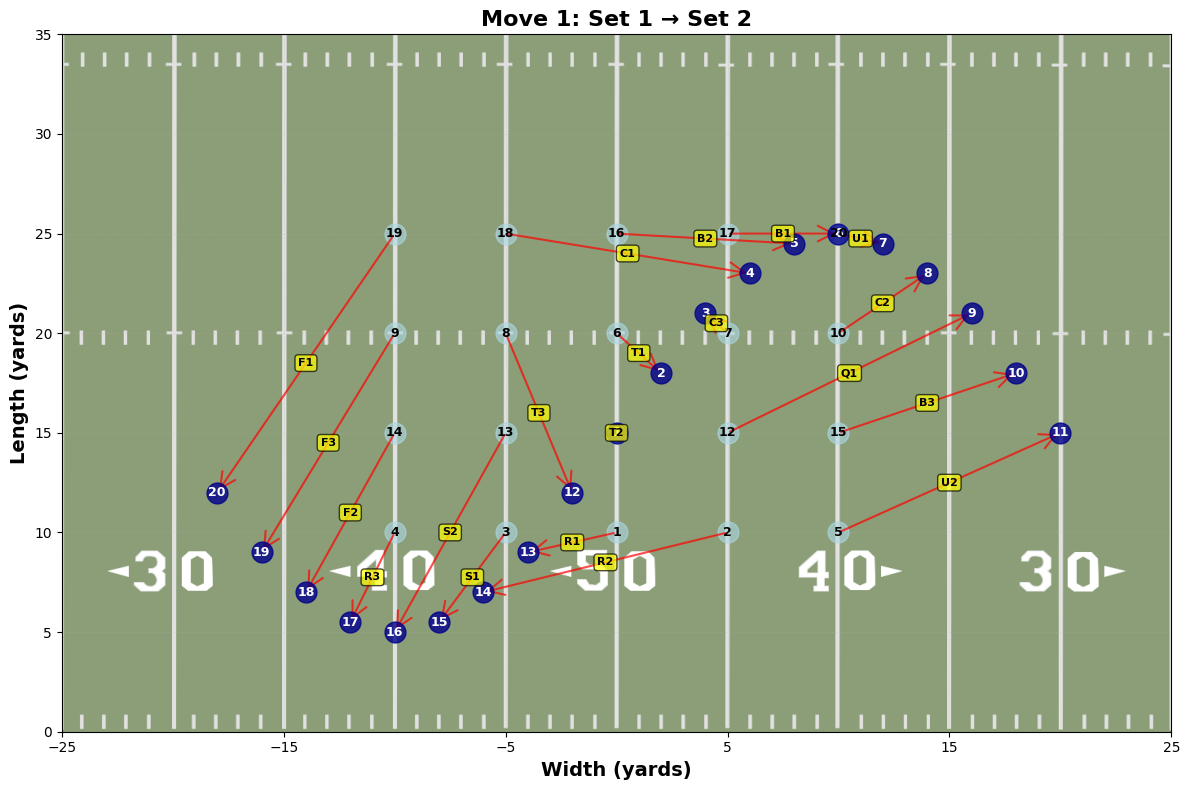


Move 2:


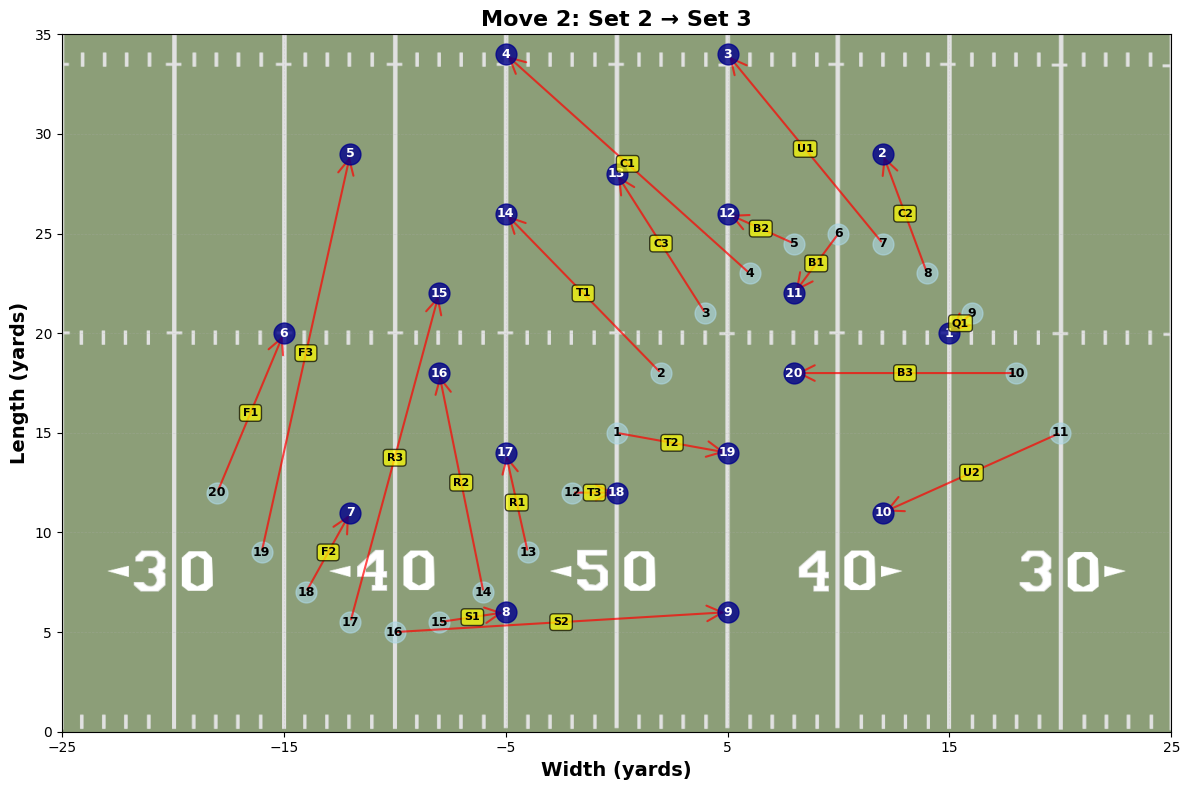

In [138]:
# Generate all moves at once
for move_idx in range(n_moves):
    print(f"\nMove {move_idx + 1}:")
    fig = visualize_move(move_idx, show_dot_numbers=True)
    plt.show()